In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !tar -xf "/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/part3.tar.gz" --directory "/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/UTKFace" --checkpoint=.100
# !tar -xf "/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/part2.tar.gz" --directory "/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/UTKFace" --checkpoint=.100
# !tar -xf "/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/part1.tar.gz" --directory "/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/UTKFace" --checkpoint=.100

## Analyzing Fairness of the Model
**NOTE:** Feel free to change the code template.

In [3]:
import cv2
import os
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
def load_dataset(path, use_less_size=False):
    data = []
    labels = []
    images = os.listdir(path)
    for image_i in range(0, 5000 if use_less_size else len(images)):
        image = images[image_i]
        img_path = os.path.join(path, image)
        if img_path.endswith('.jpg'):
          img = cv2.imread(img_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, (299, 299))  # Resize the image to 299x299
          parts = image.split('_')
          if len(parts) >= 4:
              label = int(parts[2])
              data.append(img)
              labels.append(label)
    return np.array(data), np.array(labels)

def split_train_test(X_train, y_train):
  return train_test_split(X_train, y_train, test_size = 0.3, train_size = 0.7, random_state=42, stratify=y_train)

In [5]:
#Note: Replace "/path/to/UTKFace" with the actual path to the UTKFace dataset on your local machine.
X_train, y_train = load_dataset('/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/UTKFace/part1')

X_train = X_train.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)

X_train, X_val, y_train, y_val = split_train_test(X_train, y_train)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.175)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.125)(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#TODO: Define your hyperparameters
loss_func = "categorical_crossentropy"
optim = "SGD"
batch_size = 64
epochs = 20

model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
51/51 [==============================] - 82s 844ms/step - loss: 1.8835 - accuracy: 0.3217 - val_loss: 1.4625 - val_accuracy: 0.4971
Epoch 2/20
51/51 [==============================] - 21s 415ms/step - loss: 1.2911 - accuracy: 0.5469 - val_loss: 1.2967 - val_accuracy: 0.5877
Epoch 3/20
51/51 [==============================] - 21s 417ms/step - loss: 1.0282 - accuracy: 0.6522 - val_loss: 1.1377 - val_accuracy: 0.6014
Epoch 4/20
51/51 [==============================] - 21s 419ms/step - loss: 0.8378 - accuracy: 0.7140 - val_loss: 0.9010 - val_accuracy: 0.6833
Epoch 5/20
51/51 [==============================] - 21s 421ms/step - loss: 0.6865 - accuracy: 0.7615 - val_loss: 0.9815 - val_accuracy: 0.6688
Epoch 6/20
51/51 [==============================] - 22s 424ms/step - loss: 0.5898 - accuracy: 0.7919 - val_loss: 1.2267 - val_accuracy: 0.6435
Epoch 7/20
51/51 [==============================] - 22s 424ms/step - loss: 0.

In [6]:
# Load the validation set and preprocess it
X_val, y_val = load_dataset('/content/drive/MyDrive/Masters/Sem 4/MLCV/2024-SP-101-hw4-ap43n/UTKFace/part1')
X_val = X_val.astype('float32') / 255.0
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)

# Make predictions using the trained model
y_pred = model.predict(X_val)

# Convert the one-hot encoded vectors to integer labels
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Initialize an empty dictionary to store the results
results_dict = {}

# Compute the number of positive/negative predictions for each race and store in the dictionary
races = ['White', 'Black', 'Asian', 'Indian', 'Others']
for i, race in enumerate(races):
    race_indices = np.where(y_val_labels == i)[0]
    other_indices = np.where(y_val_labels != i)[0]
    race_predictions = y_pred_labels[race_indices]
    other_predictions = y_pred_labels[other_indices]
    truePositive = np.sum(race_predictions == i)
    falseNegative = len(race_predictions) - truePositive
    falsePositive = np.sum(other_predictions == i)
    trueNegative = len(other_indices) - falsePositive

    results_dict[race] = {
        'TP': truePositive,
        'TN': trueNegative,
        'FP': falsePositive,
        'FN': falseNegative
    }

print(results_dict)

144/144 [==============================] - 16s 74ms/step
{'White': {'TP': 2419, 'TN': 1992, 'FP': 113, 'FN': 76}, 'Black': {'TP': 168, 'TN': 4379, 'FP': 11, 'FN': 42}, 'Asian': {'TP': 648, 'TN': 3835, 'FP': 44, 'FN': 73}, 'Indian': {'TP': 565, 'TN': 3879, 'FP': 38, 'FN': 118}, 'Others': {'TP': 420, 'TN': 3935, 'FP': 174, 'FN': 71}}


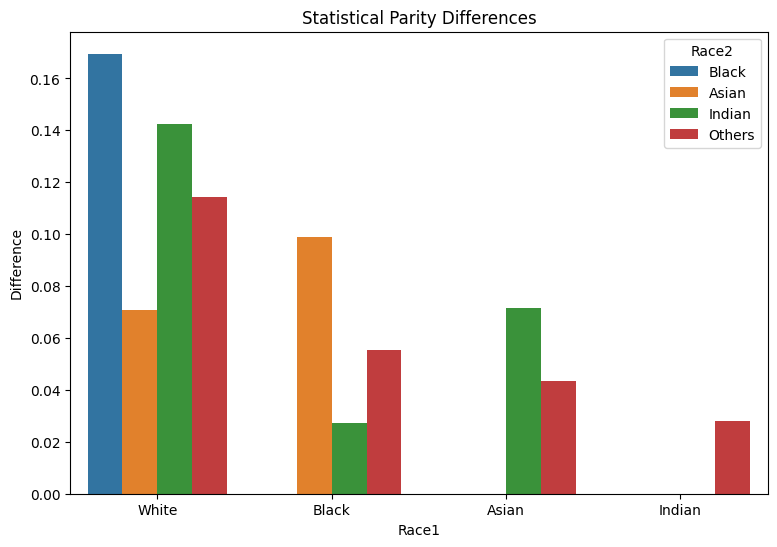

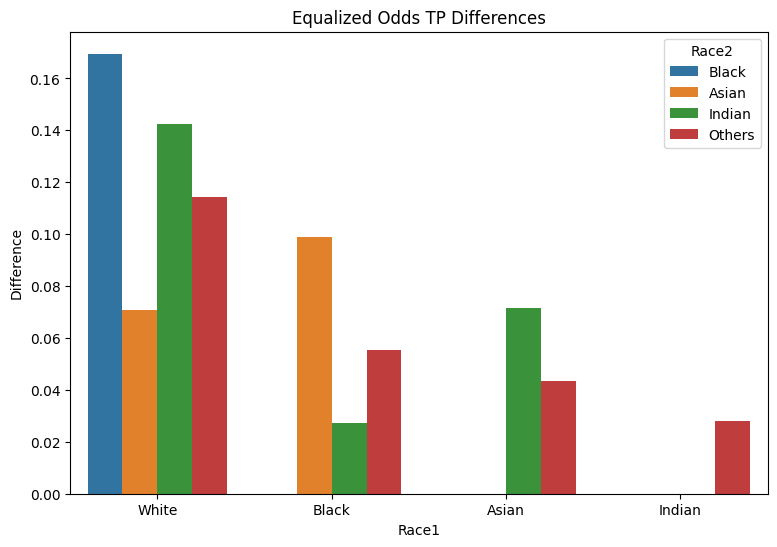

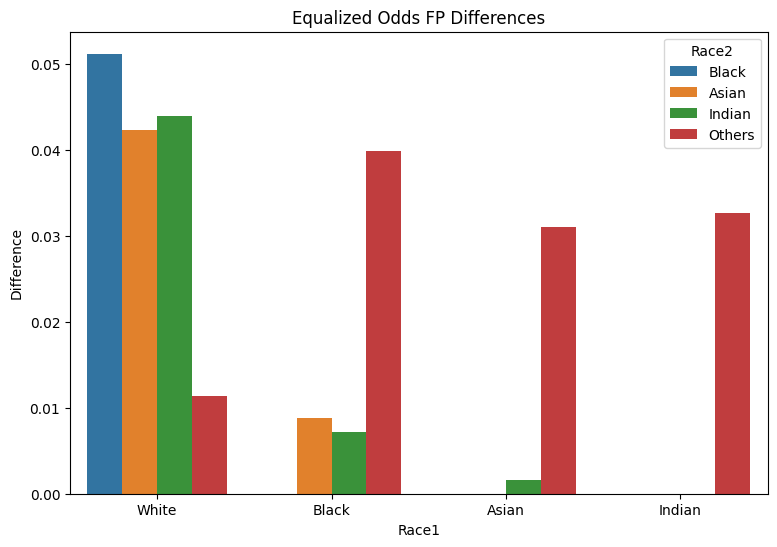

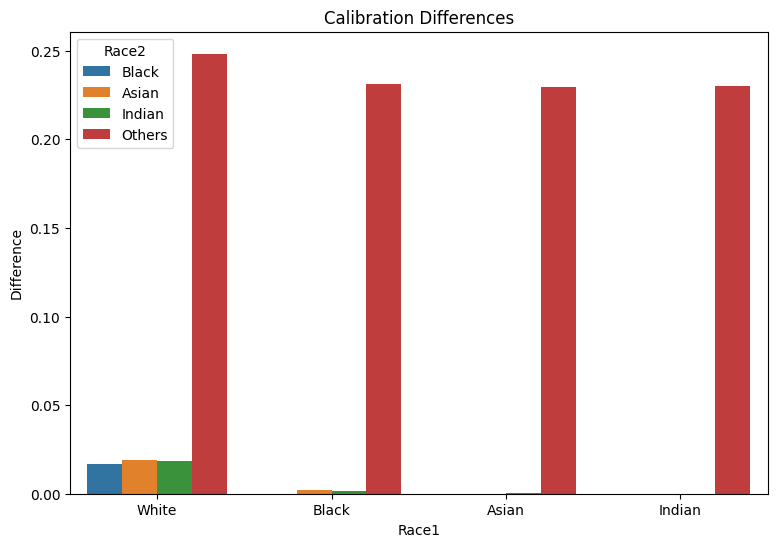

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def metrics(race1, race2, metric):
    results = {}
    if metric == 'statistical parity':
        val1 = results_dict[race1]['TP'] / (results_dict[race1]['TP'] + results_dict[race1]['FN'])
        val2 = results_dict[race2]['TP'] / (results_dict[race2]['TP'] + results_dict[race2]['FN'])
        results['difference'] = abs(val1 - val2)
    elif metric == 'equalized odds':
        trueVal1 = results_dict[race1]['TP'] / (results_dict[race1]['TP'] + results_dict[race1]['FN'])
        trueVal2 = results_dict[race2]['TP'] / (results_dict[race2]['TP'] + results_dict[race2]['FN'])
        falseVal1 = results_dict[race1]['FP'] / (results_dict[race1]['FP'] + results_dict[race1]['TN'])
        falseVal2 = results_dict[race2]['FP'] / (results_dict[race2]['FP'] + results_dict[race2]['TN'])
        results['true_difference'] = abs(trueVal1 - trueVal2)
        results['false_difference'] = abs(falseVal1 - falseVal2)
    elif metric == 'calibration':
        calibration1 = results_dict[race1]['TP'] / (results_dict[race1]['TP'] + results_dict[race1]['FP'])
        calibration2 = results_dict[race2]['TP'] / (results_dict[race2]['TP'] + results_dict[race2]['FP'])
        results['difference'] = abs(calibration1 - calibration2)
    return results

metric_results = []

races = ['White', 'Black', 'Asian', 'Indian', 'Others']
for i in range(len(races)):
    for j in range(i + 1, len(races)):
        race1 = races[i]
        race2 = races[j]
        stats = metrics(race1, race2, 'statistical parity')
        odds = metrics(race1, race2, 'equalized odds')
        calibration = metrics(race1, race2, 'calibration')
        metric_results.append((race1, race2, stats['difference'], odds['true_difference'], odds['false_difference'], calibration['difference']))

df = pd.DataFrame(metric_results, columns=['Race1', 'Race2', 'Statistical Parity', 'Equalized Odds TP', 'Equalized Odds FP', 'Calibration'])
plt.figure(figsize=(9, 6))
sns.barplot(x='Race1', y='Statistical Parity', hue='Race2', data=df)
plt.title('Statistical Parity Differences')
plt.ylabel('Difference')
plt.show()

plt.figure(figsize=(9, 6))
sns.barplot(x='Race1', y='Equalized Odds TP', hue='Race2', data=df)
plt.title('Equalized Odds TP Differences')
plt.ylabel('Difference')
plt.show()

plt.figure(figsize=(9, 6))
sns.barplot(x='Race1', y='Equalized Odds FP', hue='Race2', data=df)
plt.title('Equalized Odds FP Differences')
plt.ylabel('Difference')
plt.show()

plt.figure(figsize=(9, 6))
sns.barplot(x='Race1', y='Calibration', hue='Race2', data=df)
plt.title('Calibration Differences')
plt.ylabel('Difference')
plt.show()

## Fairness Analysis of InceptionV3 Model on UTKFace Dataset

Applying the InceptionV3 pretrained model on the UTKFace dataset with the goal of predicting the race of individuals based on their facial images yields significant insights about the model's fairness and performance. This analysis delves into the model's fairness using three critical metrics: Statistical Parity, Equalized Odds, and Calibration. These metrics help us evaluate the model's unbiased performance across various racial groups, including White, Black, Asian, Indian, and Others.

### 1) **Statistical Parity Differences**:
   - The statistical parity differences shown in the graphs reveal moderate disparities in how different races are treated. Notably, the largest differences are observed between White and all other races, indicating potential biases in the model that could disadvantage minorities. This highlights an area for further analysis and adjustment to ensure decisions are made more equitably.

### 2) **Equalized Odds Differences**:
   - The Equalized Odds metric, considering both True Positive Rate (TPR) and False Positive Rate (FPR) differences, indicates variability across racial groups. For instance, the differences between White and other races in both TPR and FPR suggest that the model does not maintain consistent error rates across groups. This is crucial as it affects the fairness in the predictive performance of the model.

### 3) **Calibration Differences**:
   - Calibration differences, which measure the accuracy of the predicted probabilities, show significant disparities, particularly for the Indian race, which has a much higher calibration difference compared to others. This suggests that predictions for the Indian group may not be as reliable, and the model's confidence in its predictions varies significantly across races.

### Discussion:
The InceptionV3 model shows a promising ability to generalize across different races on the UTKFace dataset but also exhibits areas needing improvement to enhance fairness. The observed disparities, particularly in calibration for the Indian race and Statistical Parity and Equalized Odds for the White race, highlight the need for model calibration and perhaps retraining with a more balanced dataset. Addressing these disparities is crucial for developing AI systems that are equitable and just, ensuring that the model’s utility is maximized without compromising fairness.
